### Active learning experiment

<img src="./Perception_4_ActiveLearning_7_OnlineLearning.png" alt="Drawing" style="width: 800px;"/>

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import Dataset, visualize
from augmentations import get_preprocessing, get_training_augmentation, get_validation_augmentation
import torch
import numpy as np
from tqdm import tqdm
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

### Load data

In [2]:
DATA_DIR = './data/CamVid/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

# all data paths
X_train_paths = np.array([os.path.join(x_train_dir, image_name) for image_name in os.listdir(x_train_dir)])
y_train_paths = np.array([os.path.join(y_train_dir, image_name) for image_name in os.listdir(y_train_dir)])

X_valid_paths = np.array([os.path.join(x_valid_dir, image_name) for image_name in os.listdir(x_valid_dir)])
y_valid_paths = np.array([os.path.join(y_valid_dir, image_name) for image_name in os.listdir(y_valid_dir)])

X_test_paths = np.array([os.path.join(x_test_dir, image_name) for image_name in os.listdir(x_test_dir)])
y_test_paths = np.array([os.path.join(y_test_dir, image_name) for image_name in os.listdir(y_test_dir)])

In [3]:
# select k random samples from initial dataset and treat it as initially labelled data
k = 30
selection = np.random.randint(0, len(X_train_paths), k)
X_train_paths_part = X_train_paths[selection]
y_train_paths_part = y_train_paths[selection]

In [4]:
# # labelled data part of k samples
# dataset_vis = Dataset(X_paths_part,
#                   y_paths_part,
#                   classes=['car', 'road'],
#                   augmentation=get_training_augmentation(),
#                   )

# image, mask = dataset_vis[1] # get some sample
# visualize(
#     image=image, 
#     car_mask=mask.squeeze()[...,0],
#     road_mask=mask.squeeze()[...,1],
# )

### Create model

In [5]:
from abc import ABC, abstractmethod

class BaseModel(ABC):

    def __init__(self):
        pass

    @abstractmethod
    def train(self):
        pass
    
    @abstractmethod
    def predict(self):
        pass


class Unet(BaseModel):
    
    model_type = 'Unet Resnet18'
    
    def __init__(self):
        super(Unet, self).__init__()
        # model params
        self.encoder = 'resnet18'
        self.encoder_weights = 'imagenet'
        self.classes = ['car', 'road']
        self.n_classes = 1 if len(self.classes) == 1 else (len(self.classes) + 1)
        self.activation = 'softmax2d'
        # training params
        self.learning_rate = 1e-4
        self.device = 'cuda'
        self.epochs = 1
        self.batch_size = 8
        self.model = None
        self.preprocessing_fn = smp.encoders.get_preprocessing_fn(self.encoder, self.encoder_weights)
        
    def create_model(self):
        self.model = smp.Unet(encoder_name=self.encoder,
                              encoder_weights=self.encoder_weights,
                              classes=self.n_classes,
                              activation=self.activation)
        return self.model
    
    def create_epoch_runners(self, verbose=False):
        # Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
        # IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index
        loss = smp.utils.losses.DiceLoss()
        metrics = [
            smp.utils.metrics.IoU(threshold=0.5),
        ]
        optimizer = torch.optim.Adam([ 
            dict(params=self.model.parameters(), lr=self.learning_rate),
        ])
        # create epoch runners 
        # it is a simple loop of iterating over dataloader`s samples
        train_epoch = smp.utils.train.TrainEpoch(
            self.model, 
            loss=loss, 
            metrics=metrics, 
            optimizer=optimizer,
            device=self.device,
            verbose=verbose,
        )
        valid_epoch = smp.utils.train.ValidEpoch(
            self.model, 
            loss=loss, 
            metrics=metrics, 
            device=self.device,
            verbose=verbose,
        )
        
        return train_epoch, valid_epoch
        
    def create_datasets(self, train_images_paths, train_masks_paths, valid_images_paths, valid_masks_paths):
        train_dataset = Dataset(
            train_images_paths, 
            train_masks_paths, 
            augmentation=get_training_augmentation(), 
            preprocessing=get_preprocessing(self.preprocessing_fn),
            classes=self.classes,
        )
        valid_dataset = Dataset(
            valid_images_paths,
            valid_masks_paths,
            augmentation=get_validation_augmentation(), 
            preprocessing=get_preprocessing(self.preprocessing_fn),
            classes=self.classes,
        )
        return train_dataset, valid_dataset
    
    def train(self, train_images_paths, train_masks_paths, valid_images_paths, valid_masks_paths, verbose=False):
        if self.model is None: self.create_model()
        train_epoch, valid_epoch = self.create_epoch_runners(verbose=verbose)
        train_dataset, valid_dataset = self.create_datasets(train_images_paths,
                                                            train_masks_paths,
                                                            valid_images_paths,
                                                            valid_masks_paths)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=12)
        valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)
        print (f'training Unet for {self.epochs} epochs...')
        # train loop
        max_score = 0
        for i in range(0, self.epochs):
            if verbose: print('\nEpoch: {}'.format(i))
            train_logs = train_epoch.run(train_loader)
            valid_logs = valid_epoch.run(valid_loader)
            # do something (save model, change lr, etc.)
            if max_score < valid_logs['iou_score']:
                max_score = valid_logs['iou_score']
                torch.save(self.model, './unet_best_model.pth')
                if verbose: print('Model saved!')
        # update model with the best saved
        self.model = torch.load('./unet_best_model.pth')
        
    def predict(self, image_paths):
        images = []
        for image_path in image_paths:
            # input preprocessing
            image_raw = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
            image = np.copy(image_raw)
            image = cv2.resize(image, (320, 320))
            preprocessing = get_preprocessing(self.preprocessing_fn)
            image = preprocessing(image=image)['image']
            images.append(image)
        # convert to torch tensor and do inference
        x_tensor = torch.tensor(images).to(self.device)
        predictions = self.model.predict(x_tensor)
        return predictions

training Unet for 1 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:06<00:00, 15.91it/s, dice_loss - 0.6074, iou_score - 0.132]
Model saved!


100%|██████████| 233/233 [00:18<00:00, 12.39it/s]


Entropy: 1.5618619918823242, Min entropy: 1.368712306022644, Max entropy: 1.5618619918823242


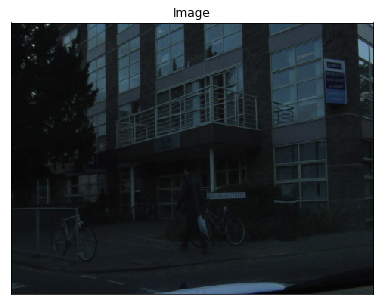

Entropy: 1.555883526802063, Min entropy: 1.368712306022644, Max entropy: 1.5618619918823242


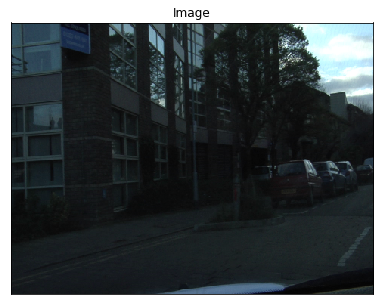

Entropy: 1.5479676723480225, Min entropy: 1.368712306022644, Max entropy: 1.5618619918823242


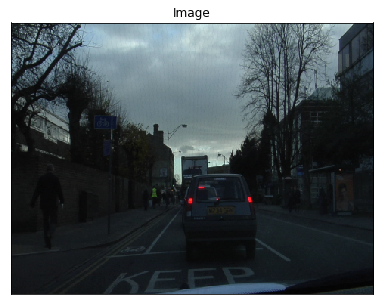

In [6]:
def entropy(mask_np):
    # mask_np.shape = (3, N, M)
    e = np.mean( (-mask_np * np.log2(mask_np)).sum(axis=0) )
    return e

AL_EXPERIMENT_ITERS = 1
NUM_CERTAIN_IMAGES = 3

# choose model
unet = Unet()

for _ in range(AL_EXPERIMENT_ITERS):
    # train model
    unet.train(X_train_paths_part, y_train_paths_part, X_valid_paths, y_valid_paths, verbose=True)
    
    # do inference and compute entropy for each image
    entropies = []
    for img_path in tqdm(X_test_paths):
        pr_mask = unet.predict([img_path])
        
        mask_np = pr_mask.squeeze().cpu().numpy()
        entropies.append(entropy(mask_np))
        
    # Model is mostly uncertain in images with High entropy
    uncertain_images = (np.argsort(entropies))[::-1][:NUM_CERTAIN_IMAGES]

    for i in uncertain_images:
        print(f'Entropy: {entropies[i]}, Min entropy: {np.min(entropies)}, Max entropy: {np.max(entropies)}')
        image = cv2.imread(X_test_paths[i])[...,(2,1,0)]
        #gt_mask = cv2.imread(y_test_paths[i])

        visualize(
            image=image,
        )